In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.preprocessing import StandardScaler

import datetime


In [50]:
df = pd.read_csv('train.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [ ]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [ ]:
df['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [51]:
# convert pickup and dropoff datetime to datetime format
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

# create pickup date and day of week
df['pickup_date'] = df['pickup_datetime'].dt.date

day_map = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek.map(day_map)
df['day_of_hour'] = df['pickup_datetime'].dt.hour
df['trip_duration_minute']=df['trip_duration']/60

In [5]:
df['day_of_week'].value_counts()

Friday       223533
Saturday     220868
Thursday     218574
Wednesday    210136
Tuesday      202749
Sunday       195366
Monday       187418
Name: day_of_week, dtype: int64

In [6]:
df['day_of_hour'].value_counts()

18    90600
19    90308
21    84185
20    84072
22    80492
17    76483
14    74292
12    71873
15    71811
13    71473
23    69785
11    68476
9     67663
8     67053
10    65437
16    64313
7     55600
0     53248
1     38571
6     33248
2     27972
3     20895
4     15792
5     15002
Name: day_of_hour, dtype: int64

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,day_of_week,day_of_hour,trip_duration_minute
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,Monday,17,7.583333
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,Sunday,0,11.050000
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,Tuesday,11,35.400000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,Wednesday,19,7.150000
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,Saturday,13,7.250000


### 1. Distribution of Trip Duration

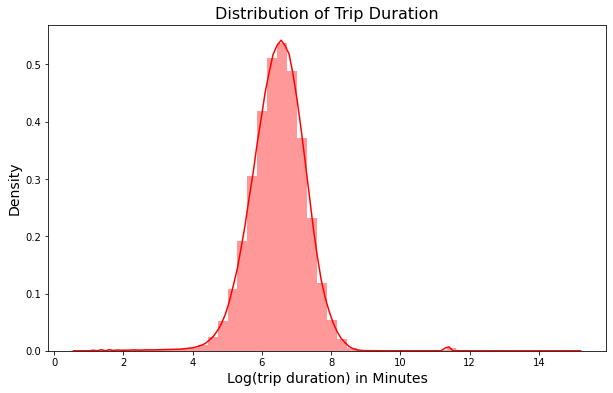

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(np.log(df['trip_duration'].values+1), \
            label='log(trip_duration)', bins=50, color='r')
plt.xlabel('Log(trip duration) in Minutes',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.title('Distribution of Trip Duration', fontsize=16)
plt.show()

### 2. Map of trip coordinates

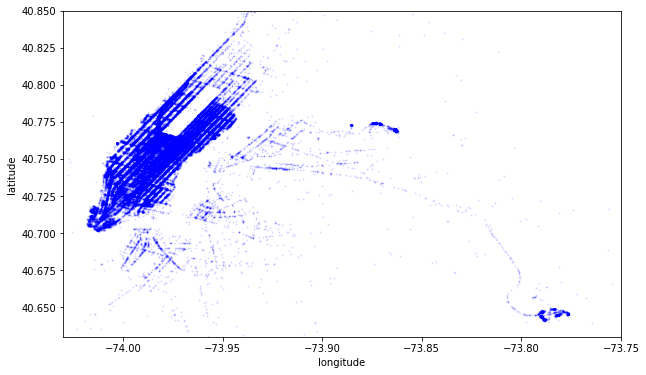

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

plt.figure(figsize=(10,6))
plt.scatter(df['pickup_longitude'].values[:100000], df['pickup_latitude'].values[:100000],
              color='blue', s=1, label='df', alpha=0.1)

plt.ylabel('latitude')
plt.xlabel('longitude')

plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()


### 3. Average Trip Duration by Vendor in Day of a Week

In [ ]:
wdays_avg_duration = pd.DataFrame(df.groupby(['day_of_week','vendor_id'])['trip_duration_minute'].mean())
wdays_avg_duration.reset_index(inplace=True)

In [ ]:
wdays_avg_duration['day_of_week']=pd.Categorical(wdays_avg_duration['day_of_week'],\
                                                 categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
wdays_avg_duration= wdays_avg_duration.sort_values(by=['day_of_week'])
wdays_avg_duration.head()

,day_of_week,vendor_id,trip_duration_minute
2,Monday,1,13.367595
3,Monday,2,16.358846
10,Tuesday,1,14.848003
11,Tuesday,2,17.721049
12,Wednesday,1,14.578025


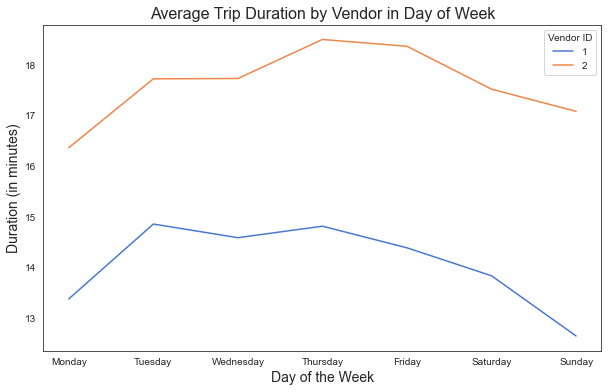

In [ ]:
plt.figure(figsize=(10,6))
sns.set_style('white')
sns.lineplot(data=wdays_avg_duration, x='day_of_week', y='trip_duration_minute', hue='vendor_id', palette='muted')
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Duration (in minutes)', fontsize=14)
plt.title('Average Trip Duration by Vendor in Day of Week', fontsize=16)
plt.legend(['1','2'], title='Vendor ID')
plt.show()

### 4. Average Trip Duration by Vendor in Day of Hour

In [ ]:
hrdays_avg_duration=pd.DataFrame(df.groupby(['day_of_hour','vendor_id'])['trip_duration_minute'].mean()).reset_index()
hrdays_avg_duration.columns=['day_of_hour','vendor_id','mean_trip_duration']
hrdays_avg_duration.head()

,day_of_hour,vendor_id,mean_trip_duration
0,0,1,14.217136
1,0,2,16.804303
2,1,1,12.298286
3,1,2,17.483206
4,2,1,11.540630


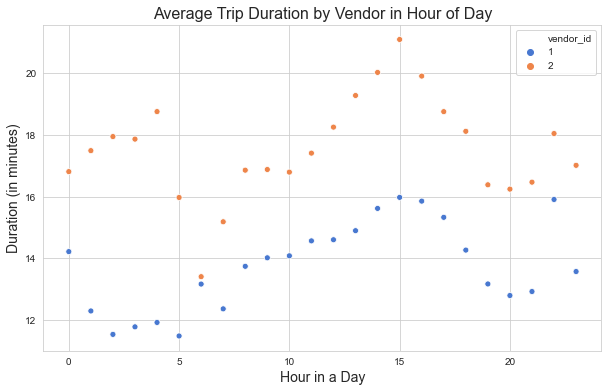

In [ ]:
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.scatterplot(x='day_of_hour',y='mean_trip_duration',data=hrdays_avg_duration,hue='vendor_id',palette='muted')
plt.xlabel('Hour in a Day', fontsize=14)
plt.ylabel('Duration (in minutes)', fontsize=14)
plt.title('Average Trip Duration by Vendor in Hour of Day', fontsize=16)
plt.show()

### 4. Number of Pickups by Day of Week

In [7]:
wdays_pickup = pd.DataFrame(df.groupby(['day_of_week','vendor_id'])['pickup_datetime'].count()).reset_index()
wdays_pickup.columns=['day_of_week','vendor_id','pickup_counts']

wdays_pickup['day_of_week']=pd.Categorical(wdays_pickup['day_of_week'],\
                                                 categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
wdays_pickup= wdays_pickup.sort_values(by=['day_of_week'])
wdays_pickup.head()


,day_of_week,vendor_id,pickup_counts
2,Monday,1,87282
3,Monday,2,100136
10,Tuesday,1,93857
11,Tuesday,2,108892
12,Wednesday,1,98090


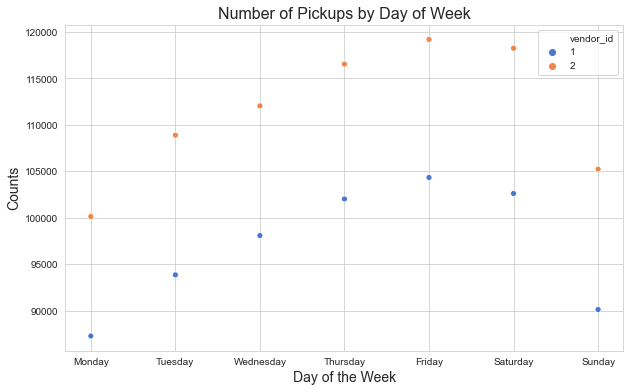

In [ ]:
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.scatterplot(x='day_of_week',y='pickup_counts',data=wdays_pickup,hue='vendor_id',palette='muted')
plt.xlabel('Day of the Week',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.title('Number of Pickups by Day of Week',fontsize=16)
plt.show()

### 5. Number of Pickups by Day of Hour

In [ ]:
hrdays_pickup=pd.DataFrame(df.groupby(['day_of_hour','vendor_id'])['pickup_datetime'].count()).reset_index()
hrdays_pickup.columns=['day_of_hour','vendor_id','pickup_counts']
hrdays_pickup.head()

,day_of_hour,vendor_id,pickup_counts
0,0,1,24561
1,0,2,28687
2,1,1,18090
3,1,2,20481
4,2,1,13570


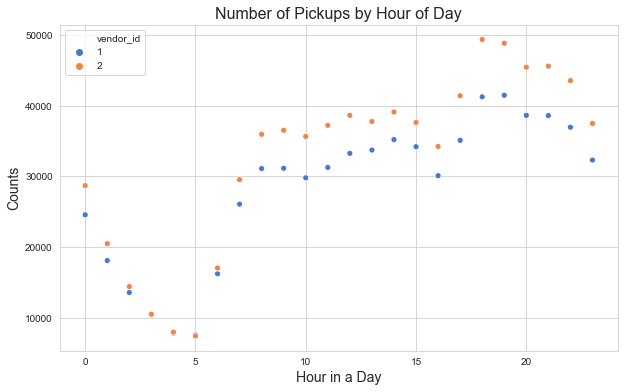

In [ ]:
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.scatterplot(x='day_of_hour',y='pickup_counts',data=hrdays_pickup,hue='vendor_id',palette='muted')
plt.xlabel('Hour in a Day', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('Number of Pickups by Hour of Day', fontsize=16)
plt.show()

### 5. Daily Average Trip Duration by Vendor 

In [ ]:
daily_avg_duration = pd.DataFrame(df.groupby(['vendor_id','pickup_date'])['trip_duration'].mean())
daily_avg_duration.reset_index(inplace=True)


daily_avg_duration.head()

,vendor_id,pickup_date,trip_duration
0,1,2016-01-01,718.280313
1,1,2016-01-02,707.772461
2,1,2016-01-03,717.476680
3,1,2016-01-04,709.356199
4,1,2016-01-05,1987.441902


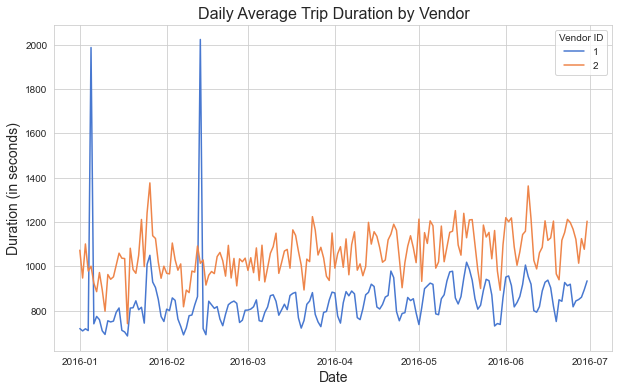

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(data=daily_avg_duration, x='pickup_date', y='trip_duration', hue='vendor_id', palette='muted')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Duration (in seconds)', fontsize=14)
plt.title('Daily Average Trip Duration by Vendor', fontsize=16)
plt.legend(['1','2'], title='Vendor ID')
plt.show()

### 6. Distribution of Pickup dates and Dropoff dates

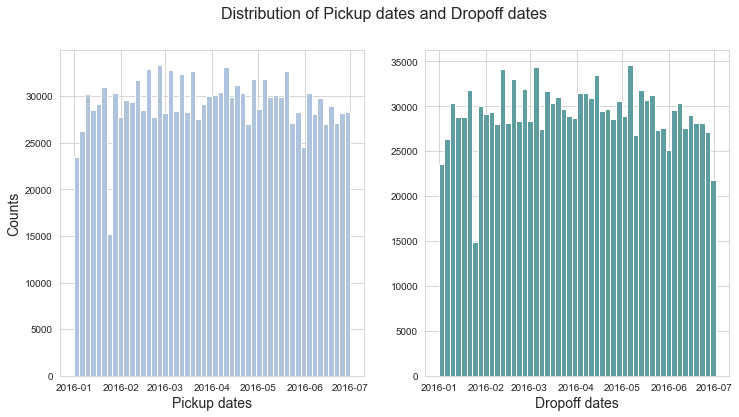

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.set_style('white')
fig.suptitle('Distribution of Pickup dates and Dropoff dates', fontsize=16)
ax[0].hist(df['pickup_datetime'],bins=50,color='lightsteelblue')
ax[1].hist(df['dropoff_datetime'],bins=50,color='cadetblue')

ax[0].set_xlabel('Pickup dates',fontsize=14)
ax[1].set_xlabel('Dropoff dates', fontsize=14)
ax[0].set_ylabel('Counts', fontsize=14)

plt.show()

### 7. Passenger Count Distribution

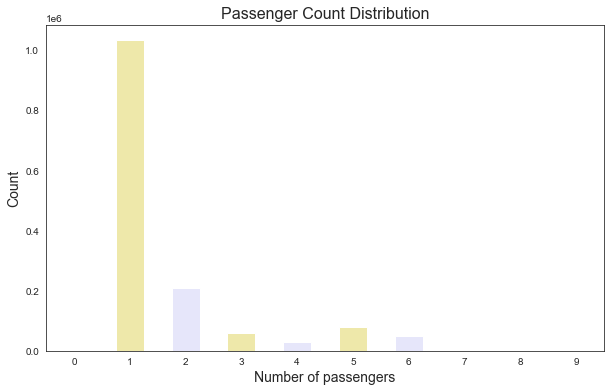

In [ ]:
df.groupby(['passenger_count'])['passenger_count'].count().plot(kind='bar',figsize=(10,6),color=['lavender','palegoldenrod'])
plt.xlabel('Number of passengers',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(rotation='horizontal')
plt.title('Passenger Count Distribution',fontsize=16)
plt.show()

### 7. Vendor ID count

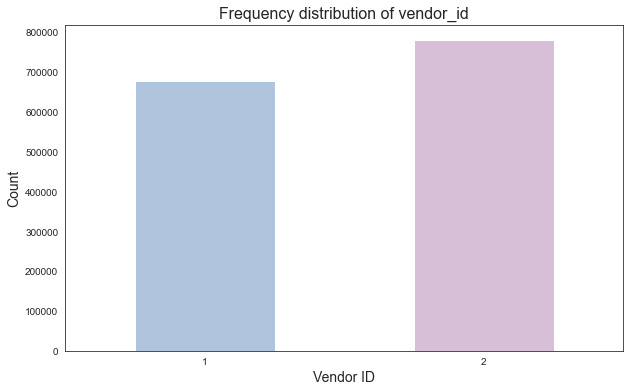

In [ ]:
df.groupby(['vendor_id'])['vendor_id'].count().plot(kind='bar',figsize=(10,6),color=['lightsteelblue','thistle'])
plt.xlabel('Vendor ID',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(rotation='horizontal')
plt.title('Frequency distribution of vendor_id',fontsize=16)
plt.show()

### 8. Distance Spread

In [41]:
def cal_distance(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat):
    
    distance_list = []
    # radius of the earth 
    R = 6373.0
    for i in range(len(pickup_lon)):
        lon1 = math.radians(pickup_lon[i])
        lat1 = math.radians(pickup_lat[i])
        lon2 = math.radians(dropoff_lon[i])
        lat2 = math.radians(dropoff_lat[i])
        # distance in lon
        dis_lon = lon2 - lon1
        # distance in lat
        dis_lat = lat2 - lat1
        # Haversine formula
        a = math.sin(dis_lat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dis_lon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = R * c   # the unit of distance is 'km'
        distance_list.append(distance)
    return pd.Series(distance_list)

In [52]:
distance = cal_distance(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])
print('The distance (in km) between pickup and dropoff location is:\n', distance)

The distance (in km) between pickup and dropoff location is:
 0          1.498991
1          1.806074
2          6.387103
3          1.485965
4          1.188962
             ...   
1458639    1.225465
1458640    6.051735
1458641    7.827062
1458642    1.092907
1458643    1.134398
Length: 1458644, dtype: float64


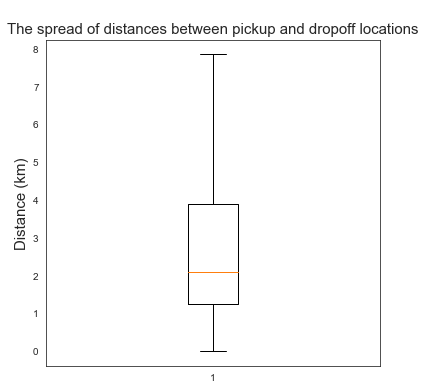

In [ ]:
plt.figure(figsize = (6, 6))
plt.boxplot(distance, showfliers=False) 
plt.ylabel('Distance (km)', fontsize = 15)
plt.title('\nThe spread of distances between pickup and dropoff locations', fontsize = 15)
plt.show()

### Feature engineering: new feature `Distance` (in km), `month`

In [53]:
#Function aiming at calculating distances from coordinates
def ft_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 #km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

#Add distance feature
df['distance'] = ft_haversine_distance(df['pickup_latitude'].values,
                                                 df['pickup_longitude'].values, 
                                                 df['dropoff_latitude'].values,
                                                 df['dropoff_longitude'].values)

In [54]:
df['distance'] = distance.to_frame(name='distance')

In [55]:
df['month'] = df['pickup_datetime'].dt.month

In [15]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,day_of_week,day_of_hour,trip_duration_minute,distance,month
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,Monday,17,7.583333,1.498991,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,Sunday,0,11.050000,1.806074,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,Tuesday,11,35.400000,6.387103,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,Wednesday,19,7.150000,1.485965,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,Saturday,13,7.250000,1.188962,3


### Train test dataset split, take log of duration as the target variable

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [56]:
# Since the training set is too large, to shorten the training time of random forest regressor, 
# only 1% of the data is used for the purpose of feature selection modeling
df = df.sample(frac=0.1, random_state=666)
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,day_of_week,day_of_hour,trip_duration_minute,distance,month
807955,id2153605,2,2016-02-10 23:13:44,2016-02-10 23:36:54,1,-73.998390,40.745201,-73.854752,40.725712,N,1390,2016-02-10,Wednesday,23,23.166667,12.298740,2
810024,id3199815,2,2016-03-15 06:40:22,2016-03-15 06:46:38,6,-73.998688,40.734921,-73.986740,40.760208,N,376,2016-03-15,Tuesday,6,6.266667,2.987495,3
512091,id3148618,2,2016-06-30 23:15:43,2016-06-30 23:26:46,1,-73.991783,40.764633,-73.967064,40.758640,N,663,2016-06-30,Thursday,23,11.050000,2.186653,6
1100633,id0060287,1,2016-04-08 00:25:45,2016-04-08 00:36:32,1,-73.984901,40.728165,-73.954170,40.770313,N,647,2016-04-08,Friday,0,10.783333,5.355824,4
865247,id0632685,1,2016-02-10 21:03:58,2016-02-10 21:08:53,1,-73.955688,40.785088,-73.969078,40.794418,N,295,2016-02-10,Wednesday,21,4.916667,1.532512,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397176,id0592128,1,2016-03-20 20:49:24,2016-03-20 21:01:26,1,-73.987854,40.724430,-74.000999,40.710438,N,722,2016-03-20,Sunday,20,12.033333,1.910611,3
1015790,id3143443,2,2016-02-13 10:31:25,2016-02-13 10:42:51,1,-73.973717,40.750408,-74.000542,40.758308,N,686,2016-02-13,Saturday,10,11.433333,2.425037,2
795545,id2035923,2,2016-01-02 23:28:20,2016-01-02 23:46:12,1,-73.976341,40.764107,-74.005890,40.740131,N,1072,2016-01-02,Saturday,23,17.866667,3.648399,1
1321048,id2713466,2,2016-06-08 10:39:57,2016-06-08 10:46:21,1,-73.978584,40.762596,-73.980270,40.765831,N,384,2016-06-08,Wednesday,10,6.400000,0.386837,6


In [57]:
X = df.drop(['id','trip_duration','pickup_date','pickup_datetime','dropoff_datetime','trip_duration_minute'], axis=1)
y = np.log(df['trip_duration'])

In [73]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=666)

In [59]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((109398, 11), (109398,), (36466, 11), (36466,))

In [18]:
X_train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day_of_week,day_of_hour,distance,month
74271,1,1,-73.987137,40.754986,-73.979912,40.739620,N,Sunday,18,1.814317,3
484810,2,1,-73.994438,40.726185,-73.981148,40.728168,N,Monday,13,1.141806,1
366156,2,2,-73.954330,40.764042,-73.982750,40.761539,N,Sunday,23,2.410400,1
1249224,1,1,-73.967361,40.760460,-73.955055,40.777298,N,Sunday,23,2.140662,5
887060,2,1,-73.976639,40.743713,-73.981789,40.720963,N,Friday,23,2.567530,5


### Dummy encoding for nominal variables

In [74]:
# encode the training set
vendor_encode1 = pd.get_dummies(X_train['vendor_id'], prefix='vendor')
passenger_cnt_encode1 = pd.get_dummies(X_train['passenger_count'], prefix='passenger')
sf_flag_encode1 = pd.get_dummies(X_train['store_and_fwd_flag'], prefix='flag')
weekday_encode1 = pd.get_dummies(X_train['day_of_week'], prefix='weekday')
hour_encode1 = pd.get_dummies(X_train['day_of_hour'], prefix='hour')
month_encode1 = pd.get_dummies(X_train['month'], prefix='month')

In [75]:
# encode the test set
vendor_encode2 = pd.get_dummies(X_test['vendor_id'], prefix='vendor')
passenger_cnt_encode2 = pd.get_dummies(X_test['passenger_count'], prefix='passenger')
sf_flag_encode2 = pd.get_dummies(X_test['store_and_fwd_flag'], prefix='flag')
weekday_encode2 = pd.get_dummies(X_test['day_of_week'], prefix='weekday')
hour_encode2 = pd.get_dummies(X_test['day_of_hour'], prefix='hour')
month_encode2 = pd.get_dummies(X_test['month'], prefix='month')

In [ ]:
passenger_cnt_encode1.shape, passenger_cnt_encode2.shape

((1021050, 9), (437594, 9))

In [76]:
numeric_train = X_train['distance']
X_train = pd.concat([vendor_encode1,passenger_cnt_encode1,sf_flag_encode1,weekday_encode1,hour_encode1,\
                     month_encode1, numeric_train], axis=1)
X_train.head()

,vendor_1,vendor_2,passenger_0,passenger_1,passenger_2,passenger_3,passenger_4,passenger_5,passenger_6,passenger_7,passenger_9,flag_N,flag_Y,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,month_1,month_2,month_3,month_4,month_5,month_6,distance
1068211,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1.038851
339366,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.880265
1091688,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,2.704341
769938,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.816621
698986,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,8.346809


In [22]:
y_train

74271      6.562444
484810     6.246107
366156     6.621406
1249224    5.389072
887060     6.075346
             ...   
1370057    5.707110
303174     6.436150
1051454    6.841615
337794     7.471932
1038572    6.054439
Name: trip_duration, Length: 1021050, dtype: float64

In [77]:
numeric_test = X_test['distance']
X_test = pd.concat([vendor_encode2,passenger_cnt_encode2,sf_flag_encode2,weekday_encode2,hour_encode2,\
                     month_encode2, numeric_test], axis=1)
X_test.head()

,vendor_1,vendor_2,passenger_0,passenger_1,passenger_2,passenger_3,passenger_4,passenger_5,passenger_6,flag_N,flag_Y,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,month_1,month_2,month_3,month_4,month_5,month_6,distance
490159,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.464414
1256968,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.821934
545130,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.923380
1162513,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,24.654554
319571,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2.982939


In [ ]:
X_train['distance'].describe()

In [78]:
# standardize the numeric variable "distance"
X_train['distance'] = (X_train['distance'] - X_train['distance'].mean())/X_train['distance'].std()
X_test['distance'] = (X_test['distance'] - X_test['distance'].mean())/X_test['distance'].std()
X_train.head()

,vendor_1,vendor_2,passenger_0,passenger_1,passenger_2,passenger_3,passenger_4,passenger_5,passenger_6,passenger_7,passenger_9,flag_N,flag_Y,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,month_1,month_2,month_3,month_4,month_5,month_6,distance
1068211,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,-0.591152
339366,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.136776
1091688,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,-0.180185
769938,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.645988
698986,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1.212117


### Feature importance visualization with Random Forest regression

In [ ]:
# Feature Importance Order Visualization for top 20 using Random Forest
forest = RandomForestRegressor()
forest.fit(X_train,y_train)

In [ ]:
#plot graph of feature importances for better visualization
plt.figure(figsize=(15,8))
feat_importances = pd.Series(forest.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Top 20 Most Important Features Visualization', fontsize=15)
plt.ylabel('Feature', fontsize=14)
plt.show()

The top 20 most importance features are
- distance
- vendor type
- which month
- whether is single passenger
- which weekday
- whether is for 2 passengers
- whether is at 6am or 3pm

We decided to include those features into our models.

### Model Building
1. Baseline model: linear model
2. Random forest regression
3. SVM regression
4. XGBoost regression
5. Multi-Layer Perceptron

In [79]:
# leave only top 20 features in X_train and X_test called X_train_fi, X_test_fi
top20_features = ['distance','vendor_1','vendor_2','month_5','month_3','month_6','month_1','month_4','month_2',\
                 'passenger_1','weekday_Saturday','weekday_Friday','weekday_Sunday','weekday_Tuesday','passenger_2',\
                 'weekday_Thursday','weekday_Monday','weekday_Wednesday','hour_6','hour_15']
X_train_fi = X_train[top20_features]
X_test_fi = X_test[top20_features]
X_train_fi.columns

Index(['distance', 'vendor_1', 'vendor_2', 'month_5', 'month_3', 'month_6',
       'month_1', 'month_4', 'month_2', 'passenger_1', 'weekday_Saturday',
       'weekday_Friday', 'weekday_Sunday', 'weekday_Tuesday', 'passenger_2',
       'weekday_Thursday', 'weekday_Monday', 'weekday_Wednesday', 'hour_6',
       'hour_15'],
      dtype='object')

* Baseline model: Linear regression 

In [80]:
# define the linear regression model
lr = linear_model.LinearRegression()

# fit model
lr.fit(X_train_fi, y_train)

# predict on test data
y_train_pred_lr = lr.predict(X_train_fi)
y_test_pred_lr = lr.predict(X_test_fi)


# evaluate model
# coefficients and intercept
print(lr.coef_)
print(lr.intercept_)

# MSE for training data and test data: compare to see if overfitting exists
print('MSE for training data:', mean_squared_error(y_train_pred_lr, y_train))
print('MSE for test data:', mean_squared_error(y_test_pred_lr, y_test))

# r2 score: model fit
print('R2 score:', r2_score(y_test, y_test_pred_lr))

[ 0.48782093 -0.00951589  0.00951589  0.04044007 -0.01821666  0.03401578
 -0.04654522  0.01985236 -0.02954633 -0.02470804 -0.03721859  0.0399463
 -0.12903479  0.03838645  0.00548978  0.07436684 -0.048645    0.0621988
 -0.36510044  0.11448885]
6.482169744935712
MSE for training data: 0.39489646741439566
MSE for test data: 0.4179322616642625
R2 score: 0.35046126562105884


K-Fold cross validation

In [81]:
train_data = X_train_fi.join(y_train)
test_data = X_test_fi.join(y_test)
data = pd.concat([train_data, test_data], axis = 0)

In [82]:
# K-Fold cross validation: split data into training data and test data, and each split data has to be used as test data only once 

# define an empty MSE list for KFold cv in linear reg
kfold_mse_lr_list = []
print('MSE for K-fold cv in the linear regression model:')

for train_id, test_id in KFold(n_splits = 5, shuffle = True, random_state = 666).split(data.index): # k = 5, 5-fold cv
    # extract training data and test data
    train = data.iloc[train_id,:]
    test = data.iloc[test_id,:]
    # define lr model
    lr_cv = linear_model.LinearRegression()
    # fit 
    lr_cv.fit(train.drop('trip_duration', axis = 1), train['trip_duration'])
    # predict
    cv_pred_lr = lr_cv.predict(test.drop('trip_duration', axis=1))

    # evaluate 
    # MSE for test data
    kfold_mse_lr = mean_squared_error(test['trip_duration'], cv_pred_lr)
    # add each MSE to the list
    kfold_mse_lr_list.append(kfold_mse_lr)

    print(kfold_mse_lr)
    
print ('\nMean of MSE for K-fold cv in linear regression:', pd.Series(kfold_mse_lr_list).mean())   

MSE for K-fold cv in the linear regression model:
0.3847255913806272
0.3766768001420808
0.4162010727447603
0.42357010612744156
0.4106201963899443

Mean of MSE for K-fold cv in linear regression: 0.40235875335697086


Model performance

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


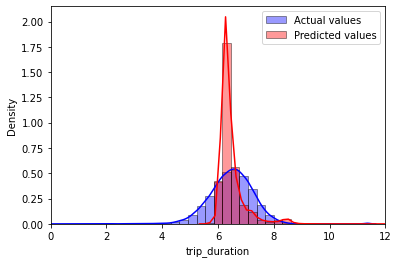

In [83]:
# histograms of predicted values and actual values: see the distribution
bins = np.linspace(0, 12, 40)
sns.distplot(y_test, hist = True, bins=bins, color = 'b',
             hist_kws={'edgecolor':'black'}, label = 'Actual values')
sns.distplot(y_test_pred_lr, hist=True, bins=bins, color = 'r', 
             hist_kws={'edgecolor':'black'},  label = 'Predicted values')
plt.xlim(0, 12)
plt.legend(loc='upper right')
plt.show()

In [214]:
# check the MSE for each feature value

# join the predicted values and test data: make the predicted value to a df and re-index it
y_test_pred_lr_df = pd.DataFrame(y_test_pred_lr).rename(columns = {0:'pred_duration'})
y_test_pred_lr_df = y_test_pred_lr_df.set_index([pd.Index(y_test.index)])
test_data_lr = y_test_pred_lr_df.join(test_data)

# define a function to compute the MSE for each nominal feature value (after dummy-encoding)
def feature_mse(data, feature, featValue):
    # filter the data with a specific feature level 
    # for each feature level, get the predicted values  
    pred_for_feature = data.loc[data[feature] == featValue, 'pred_duration'] 
    # and the actual values
    y_test_for_feature = data.loc[data[feature] == featValue, 'trip_duration'] 
    # compute the MSE
    mse_for_feature = mean_squared_error(pred_for_feature, y_test_for_feature)
    return mse_for_feature

# define a function to use the above function to each nominal feature level
def compute_feaMSE(data):
  # vendor_id
  mse_for_vendor1 = feature_mse(data, 'vendor_1', 1)
  mse_for_vendor2 = feature_mse(data, 'vendor_2', 1)
  # month
  mse_for_month5 = feature_mse(data, 'month_5', 1)
  mse_for_month3 = feature_mse(data, 'month_3', 1)
  mse_for_month6 = feature_mse(data, 'month_6', 1)
  mse_for_month1 = feature_mse(data, 'month_1', 1)
  mse_for_month4 = feature_mse(data, 'month_4', 1)
  mse_for_month2 = feature_mse(data, 'month_2', 1)
  # passenger_count
  mse_for_passenger1 = feature_mse(data, 'passenger_1', 1)
  mse_for_passenger2 = feature_mse(data, 'passenger_2', 1)
  # weekday
  mse_for_weekdaySat = feature_mse(data, 'weekday_Saturday', 1)
  mse_for_weekdayFri = feature_mse(data, 'weekday_Friday', 1)
  mse_for_weekdaySun = feature_mse(data, 'weekday_Sunday', 1)
  mse_for_weekdayTues = feature_mse(data, 'weekday_Tuesday', 1)
  mse_for_weekdayThurs = feature_mse(data, 'weekday_Thursday', 1)
  mse_for_weekdayMon = feature_mse(data, 'weekday_Monday', 1)
  mse_for_weekdayWed = feature_mse(data, 'weekday_Wednesday', 1)
  # hour
  mse_for_hr6 = feature_mse(data, 'hour_6', 1)
  mse_for_hr15 = feature_mse(data, 'hour_15', 1)
  return mse_for_vendor1, mse_for_vendor2, mse_for_month5, mse_for_month3, mse_for_month6, mse_for_month1, mse_for_month4, mse_for_month2, \
  mse_for_passenger1, mse_for_passenger2, mse_for_weekdaySat, mse_for_weekdayFri, mse_for_weekdaySun, mse_for_weekdayTues, mse_for_weekdayThurs, mse_for_weekdayMon, \
  mse_for_weekdayWed, mse_for_hr6, mse_for_hr15


def distanceMSE(data):
  # distance is a float value in [0, 1241.30], so divide the values into categories and define a similar function as above to get MSE for each category
  # filter the data with a specific feature level: 
  # [min, Q1]
  pred_for_distance1 = test_data_lr.loc[(data['distance'] >= distance.min()) & (data['distance'] < np.quantile(distance, 0.25)), 'pred_duration'] 
  y_test_for_distance1 = test_data_lr.loc[(data['distance'] >= distance.min()) & (data['distance'] < np.quantile(distance, 0.25)), 'trip_duration'] 
  mse_for_distance_short = mean_squared_error(pred_for_distance1, y_test_for_distance1)
  # [Q1, median]
  pred_for_distance2 = test_data_lr.loc[(data['distance'] >= np.quantile(distance, 0.25)) & (data['distance'] < distance.median()), 'pred_duration'] 
  y_test_for_distance2 = test_data_lr.loc[(data['distance'] >= np.quantile(distance, 0.25)) & (data['distance'] < distance.median()), 'trip_duration'] 
  mse_for_distance_short2medium = mean_squared_error(pred_for_distance2, y_test_for_distance2)
  # [median, Q3]
  pred_for_distance3 = test_data_lr.loc[(data['distance'] >= distance.median()) & (data['distance'] < np.quantile(distance, 0.75)), 'pred_duration'] 
  y_test_for_distance3 = test_data_lr.loc[(data['distance'] >= distance.median()) & (data['distance'] < np.quantile(distance, 0.75)), 'trip_duration'] 
  mse_for_distance_medium2long = mean_squared_error(pred_for_distance2, y_test_for_distance2)
  # [Q3, max]
  pred_for_distance4 = test_data_lr.loc[(data['distance'] >= np.quantile(distance, 0.75)) & (data['distance'] <= distance.max()), 'pred_duration'] 
  y_test_for_distance4 = test_data_lr.loc[(data['distance'] >= np.quantile(distance, 0.75)) & (data['distance'] <= distance.max()), 'trip_duration'] 
  mse_for_distance_long = mean_squared_error(pred_for_distance4, y_test_for_distance4)

  return mse_for_distance_short, mse_for_distance_short2medium, mse_for_distance_medium2long, mse_for_distance_long

The MSE for distrance: [0.29795208 0.22922142 0.22922142 2.32907646]
The MSE for each nominal feature value: [0.42675495 0.41016217 0.39705947 0.36906645 0.41352122 0.3759213
 0.39356709 0.56127348 0.39637811 0.34733249 0.38035    0.38876382
 0.3633149  0.40143069 0.41427688 0.35853354 0.61168137 0.34422954
 0.42670654]


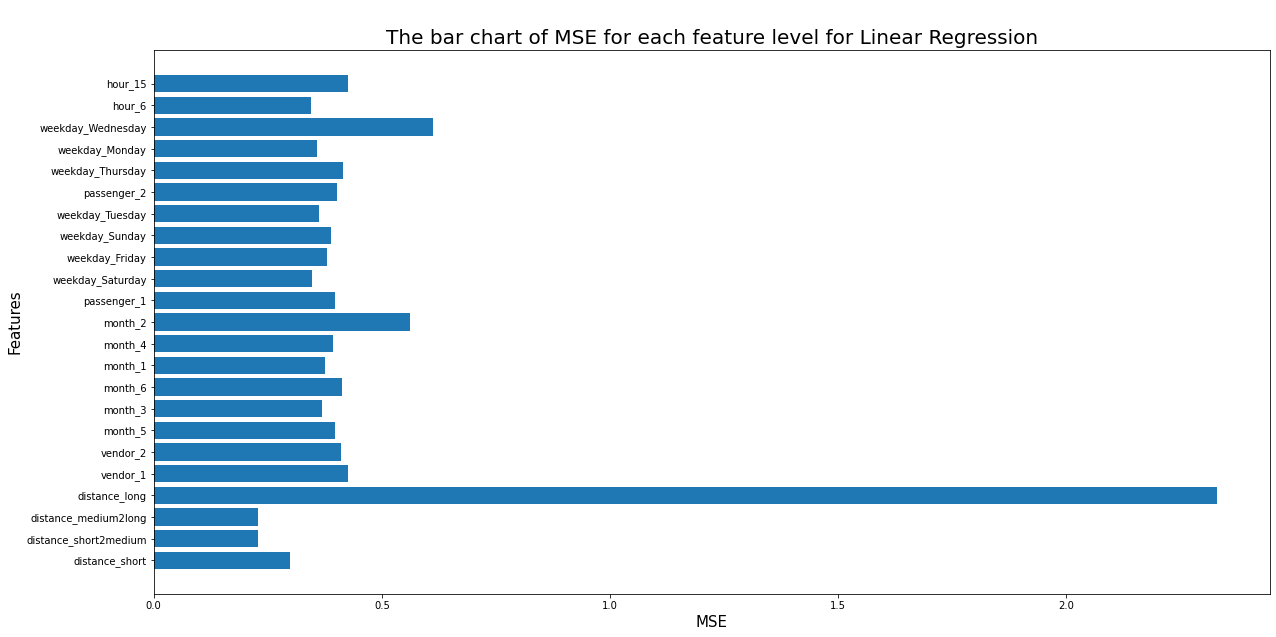

In [215]:
dist_mse_lr = np.array(distanceMSE(test_data_lr))
print('The MSE for distrance:', dist_mse_lr)
feature_mse_lr = np.array(compute_feaMSE(test_data_lr))
print('The MSE for each nominal feature value:', feature_mse_lr)
feat_mse_lr = np.concatenate([dist_mse_lr, feature_mse_lr])

# bar chart
plt.figure(figsize = (20, 10))
y = ['distance_short', 'distance_short2medium', 'distance_medium2long', 'distance_long', 'vendor_1','vendor_2','month_5','month_3','month_6','month_1','month_4','month_2',
     'passenger_1','weekday_Saturday','weekday_Friday','weekday_Sunday','weekday_Tuesday','passenger_2',
     'weekday_Thursday','weekday_Monday','weekday_Wednesday','hour_6','hour_15']
y_pos = range(1, 24)
plt.barh(y_pos, feat_mse_lr)
plt.ylabel('Features', fontsize = 15)
plt.xlabel('MSE', fontsize = 15)
plt.title('\nThe bar chart of MSE for each feature level for Linear Regression', fontsize = 20)
plt.yticks(y_pos, y)
plt.show()

* XGBoost regression




In [173]:
# XGB
import xgboost as xgb
#xgb_reg = xgb.XGBRegressor(booster = 'gbtree', objective ='reg:squarederror', learning_rate = 0.1, max_depth = 5, reg_alpha = 0.1, reg_lambda = 0, n_estimators = 100)
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', reg_alpha = 0, reg_lambda = 0.5, max_depth = 3, n_estimators = 150, random_state = 666)
xgb_reg.fit(X_train_fi,y_train)

y_train_pred_xgb = xgb_reg.predict(X_train_fi)
y_test_pred_xgb = xgb_reg.predict(X_test_fi)
print('MSE: ', mean_squared_error(y_train_pred_xgb, y_train))
print('MSE: ', mean_squared_error(y_test_pred_xgb, y_test))

MSE:  0.2305911121657691
MSE:  0.25544292983391875


Tune hyperparameters

In [175]:
# tune hyperparameters
# define the XGBRegressor
xgb_reg_gs = xgb.XGBRegressor(objective = 'reg:squarederror', booster = 'gbtree') 
# parameter values
grid_values = {'learning_rate': [0.1, 0.2, 0.5], 'reg_lambda': [0.2, 0.5], 'max_depth':[3, 5], 'n_estimatros':[100, 150, 200]} 
               #'colsample_bytree': [0.1, 0.3, 0.5, 0.8, 1], 'colsample_bylevel':} 
cv = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 666) 
xgb_reg_gs = GridSearchCV(xgb_reg_gs, param_grid = grid_values, cv = cv, scoring = 'neg_mean_squared_error')

# fit model 
xgb_reg_gs.fit(X_train_fi, y_train)

# best parameters
print('The best parameters:', xgb_reg_gs.best_params_) 

# predict values based on new parameters
y_train_pred_xgb_1 = xgb_reg_gs.predict(X_train_fi)
y_pred_xgb_1 = xgb_reg_gs.predict(X_test_fi)
print('MSE: ', mean_squared_error(y_train_pred_xgb_1, y_train))
print('MSE for the XGBoosting Regressor after tuning hyparameters:', mean_squared_error(y_pred_xgb_1, y_test))

The best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimatros': 150, 'reg_lambda': 0.5}
MSE for the XGBoosting Regressor after tuning hyparameters: 0.25381272081320577


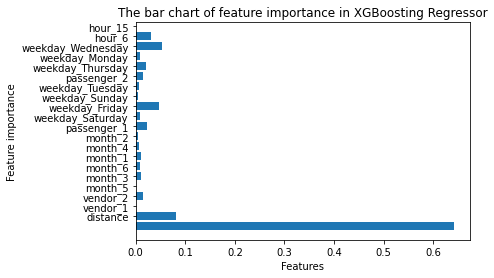

In [198]:
# feature importance
xgb_feat_importance = xgb_reg_gs.best_estimator_.feature_importances_
#xgb_feat_importance_index = xgb_reg_gs.best_estimator_.feature_importances_.argsort()

y = ['distance', 'vendor_1','vendor_2',
     'month_5','month_3','month_6','month_1','month_4','month_2',
     'passenger_1','weekday_Saturday','weekday_Friday','weekday_Sunday','weekday_Tuesday','passenger_2',
     'weekday_Thursday','weekday_Monday','weekday_Wednesday','hour_6','hour_15']
y_pos = range(1, 21)
#plt.barh(y[xgb_feat_importance_index], xgb_feat_importance[xgb_feat_importance_index])
plt.barh(y, xgb_feat_importance)
plt.ylabel('Feature importance') 
plt.xlabel('Features')
plt.title('The bar chart of feature importance in XGBoosting Regressor')
plt.yticks(y_pos, y)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


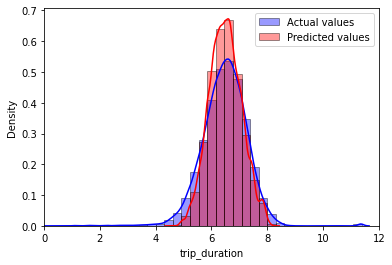

In [200]:
# histograms of predicted values and actual values: see the distribution
bins = np.linspace(0, 12, 40)
sns.distplot(y_test, hist = True, bins=bins, color = 'b',
             hist_kws={'edgecolor':'black'}, label = 'Actual values')
sns.distplot(y_pred_xgb_1, hist=True, bins=bins, color = 'r', 
             hist_kws={'edgecolor':'black'},  label = 'Predicted values')
plt.xlim(0, 12)
plt.legend(loc='upper right')

The MSE for distrance: [0.29795208 0.22922142 0.22922142 2.32907646]
The MSE for each nominal feature value: [0.21745158 0.28583577 0.25613018 0.23836897 0.27934032 0.24941979
 0.2560532  0.24428968 0.25564112 0.22870588 0.25091479 0.26045087
 0.22830386 0.26185725 0.27149205 0.22590176 0.27189534 0.19579625
 0.26668539]


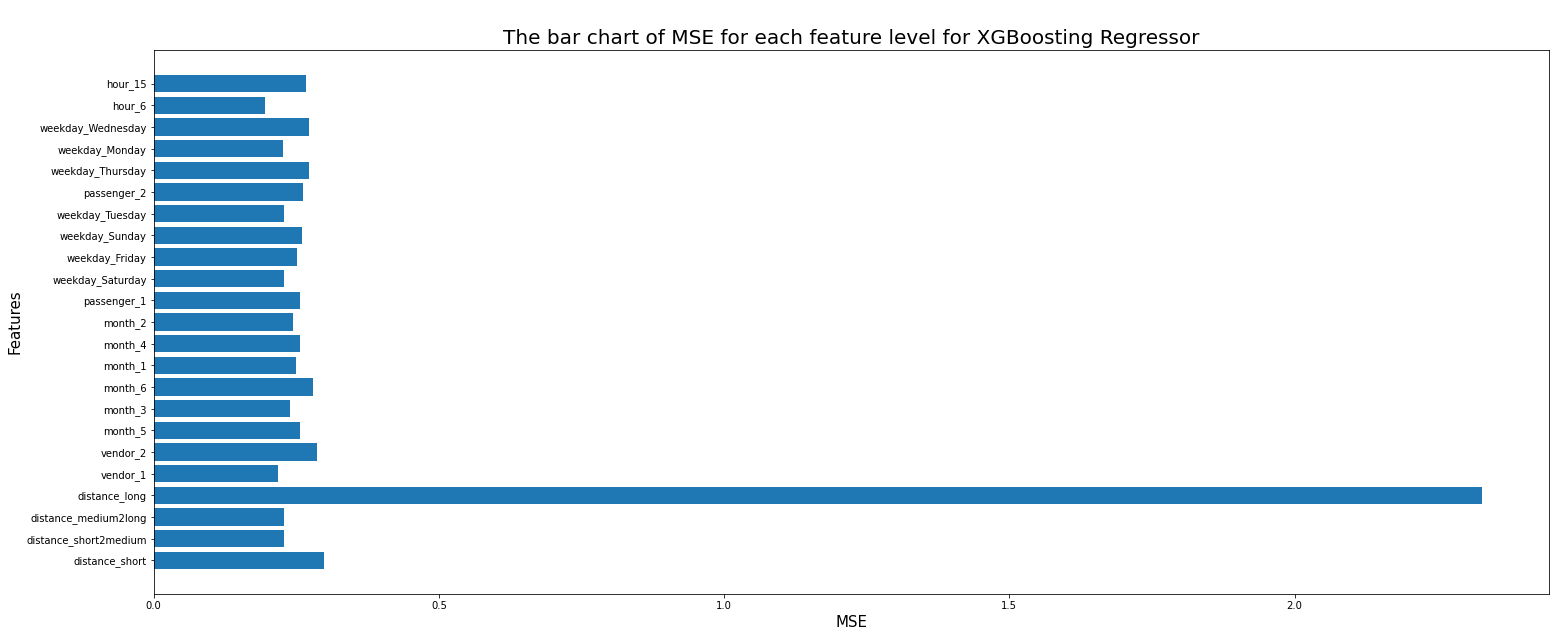

In [218]:
# check the MSE for each feature value

# join the predicted values and test data: make the predicted value to a df and re-index it
y_test_pred_xgb_df = pd.DataFrame(y_pred_xgb_1).rename(columns = {0:'pred_duration'})
y_test_pred_xgb_df = y_test_pred_xgb_df.set_index([pd.Index(y_test.index)])
test_data_xgb = y_test_pred_xgb_df.join(test_data)

# use the above defined function to compute the MSE for each feature value
dist_mse_xgb = np.array(distanceMSE(test_data_xgb))
print('The MSE for distrance:', dist_mse_xgb)
feature_mse_xgb = np.array(compute_feaMSE(test_data_xgb))
print('The MSE for each nominal feature value:', feature_mse_xgb)
feat_mse_xgb = np.concatenate([dist_mse_xgb, feature_mse_xgb])

# bar chart
plt.figure(figsize = (25, 10))
y = ['distance_short', 'distance_short2medium', 'distance_medium2long', 'distance_long','vendor_1','vendor_2','month_5','month_3','month_6','month_1','month_4','month_2',
     'passenger_1','weekday_Saturday','weekday_Friday','weekday_Sunday','weekday_Tuesday','passenger_2',
     'weekday_Thursday','weekday_Monday','weekday_Wednesday','hour_6','hour_15']
y_pos = range(1, 24)
plt.barh(y_pos, feat_mse_xgb)
plt.ylabel('Features', fontsize = 15)
plt.xlabel('MSE', fontsize = 15)
plt.title('\nThe bar chart of MSE for each feature level for XGBoosting Regressor', fontsize = 20)
plt.yticks(y_pos, y)
plt.show()